# L4: Multimodal Retrieval Augmented Generation (MM-RAG)
This project implements a system that retrieves relevant images from a database based on text queries and generates detailed descriptions of these images using a multimodal AI model.

## Key Features

1. **Image Retrieval**: Uses a vector database (Weaviate) to fetch images relevant to a query.
2. **Image Description**: Employs a generative AI model to provide detailed, context-aware descriptions of the retrieved images.
3. **Query Integration**: Combines image retrieval and description generation in a seamless workflow.

## Workflow

1. Input a text query (e.g., "dogs eating happily").
2. Retrieve and display relevant images.
3. Generate and return detailed descriptions for each image.

>In this lesson you'll learn how to leverage Weaviate and Google Gemini Pro Vision to carry out a simple multimodal RAG workflow.

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -U weaviate-client
    !pip install google-generativeai
```

In [101]:
import warnings
warnings.filterwarnings("ignore")

## Setup
### Load environment variables and API keys

In [102]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

> Note: learn more about [GOOGLE_API_KEY](https://ai.google.dev/) to run it locally.

### Connect to Weaviate

In [103]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.4",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/L4/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 2910


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-11-20T13:01:55Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-11-20T13:01:55Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-11-20T13:01:55Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2024-11-20T13:01:55Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2024-11-20T13:01:55Z"}


True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:95b674e9-1a6f-433d-8c2f-f2aad030150d Type:INIT Version:1.24.4 Modules:backup-filesystem,multi2vec-palm NumObjects:0 OS:linux Arch:amd64}","time":"2024-11-20T13:01:55Z"}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 5.728035ms","time":"2024-11-20T13:01:56Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-11-20T13:01:56Z","took":131859551}


### Restore 13k+ prevectorized resources

In [104]:
client.collections.delete("Resources")

In [105]:
client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2024-11-20T13:02:02Z","took":1396608}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 4.359391ms","time":"2024-11-20T13:02:02Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2024-11-20T13:02:02Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2024-11-20T13:02:02Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-11-20T13:02:03Z","took":114696057}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"coordinator: backup restored successfully","time":"2024-11-20T13:02:04Z"}


### Preview data count

In [106]:
from weaviate.classes.aggregate import GroupByAggregate

resources = client.collections.get("Resources")

response = resources.aggregate.over_all(
    group_by=GroupByAggregate(prop="mediaType")
)

# print rounds names and the count for each
for group in response.groups:
    print(f"{group.grouped_by.value} count: {group.total_count}")

image count: 13394
video count: 200


## Multimodal RAG

### Step 1 – Retrieve content from the database with a query

In [107]:
from IPython.display import Image
from weaviate.classes.query import Filter

def retrieve_image(query):
    resources = client.collections.get("Resources")

    response = resources.query.near_text(
        query=query,
        filters=Filter.by_property("mediaType").equal("image"), # only return image objects
        return_properties=["path"],
        limit = 1,
    )
#     print(response)

    result = response.objects[0].properties
    
    return result["path"] # Get the image path

In [108]:
def retrieve_image_list(query):
    resources = client.collections.get("Resources")

    # Query the collection
    response = resources.query.near_text(
        query=query,
        filters=Filter.by_property("mediaType").equal("image"),  # only return image objects
        return_properties=["path"],  # Return the path property of the images
        limit=3,  # Limit to 3 results
    )

    # Extract paths from the response
    result_list = []
    for obj in response.objects:
        if "path" in obj.properties:  # Ensure the path property exists
            result_list.append(obj.properties["path"])

    return result_list  # Return the list of paths


### Run image retrieval

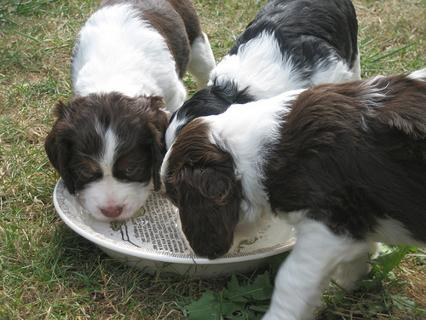

In [109]:
# Try with different queries to retreive an image
img_path = retrieve_image("dogs eating happily")
display(Image(img_path))

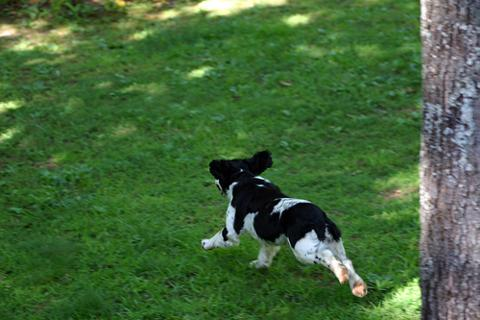

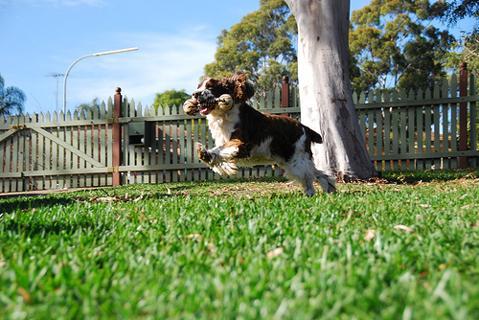

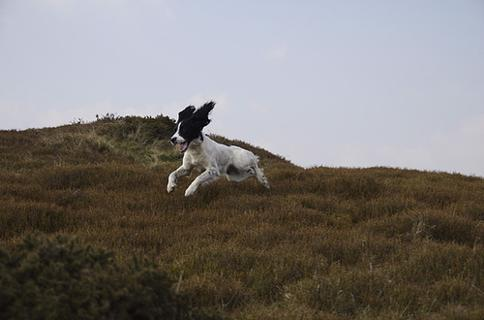

In [110]:
img_path_list = retrieve_image_list("A dog chasing")
for img_path in img_path_list:
    display(Image(img_path))

In [111]:
img_path

'./source/image/n02102040_3418.JPEG'

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Files and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


### Step 2 - Generate a description of the image

In [112]:
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

# Set the Vision model key
genai.configure(
        api_key=GOOGLE_API_KEY,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

In [113]:
# Helper function
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str) -> str:
    img = PIL.Image.open(image_path)

    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content([img,"\n\n", prompt])
#     response.resolve()

    return to_markdown(response.text)    

### Run vision request

In [114]:
call_LMM(img_path, "Please describe this image in detail.")

> Eye-level view of a black and white Springer Spaniel dog running across a grassy, hilly landscape. 
> 
> 
> Here's a breakdown of the image:
> 
> * **The Dog:** The dog is the central focus, appearing mid-stride with its ears flapping in the wind. Its fur is predominantly white with black markings on its head and along its back. The dog seems energetic and is in full motion.
> 
> * **The Landscape:** The terrain is a gently rolling hill covered in low, brownish-gold vegetation that appears dry or dormant. The grass is relatively uniform in height and color, with minimal variation in texture. The sky is a very light, almost washed-out gray-white, indicating an overcast day. There are no trees or other significant features visible in the landscape besides the grass.
> 
> * **Overall:** The image has a calm, somewhat desolate feel, emphasizing the dog's movement against the quiet backdrop. The color palette is muted and natural, with browns, golds, and the pale sky dominating. The photo appears to be taken outdoors in natural light. The focus is sharp on the dog, while the background is slightly softer.


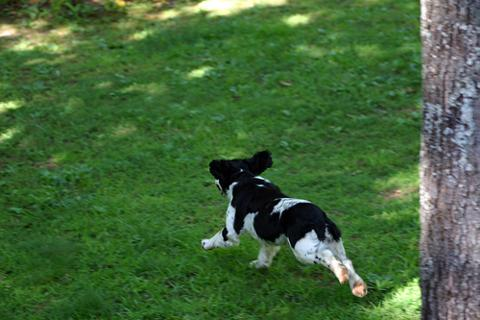

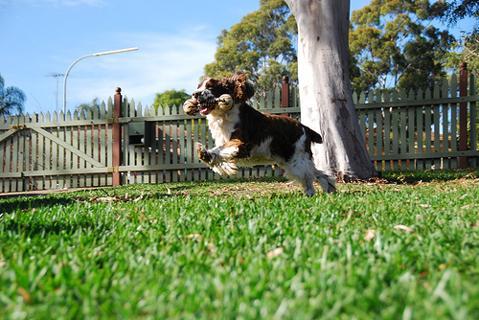

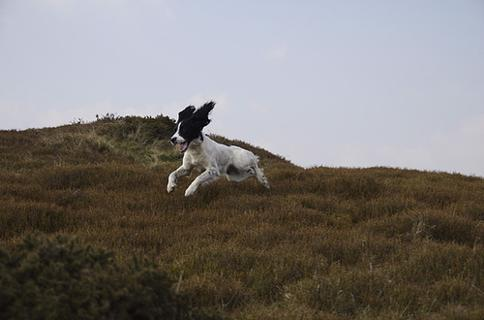

In [115]:
img_path_list = retrieve_image_list("A dog chasing")
for img_path in img_path_list:
    display(Image(img_path))
    call_LMM(img_path, "Please describe this image in detail.")
    

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## All together

In [116]:
def mm_rag(query):
    # Step 1 - retrieve an image – Weaviate
    SOURCE_IMAGE = retrieve_image(query)
    display(Image(SOURCE_IMAGE))
#===========

    # Step 2 - generate a description - GPT4
    description = call_LMM(SOURCE_IMAGE, "Please describe this image in detail.")
    return description

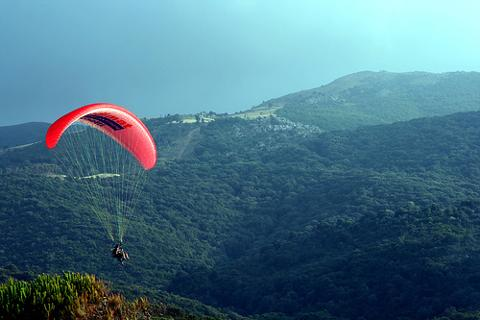

> Here's a description of the image:
> 
> Eye-level view of a red paraglider soaring over a vast, mountainous landscape. 
> 
> 
> Here's a breakdown of the image's components:
> 
> * **The Paraglider:** A vibrant red paragliding canopy is the central focus, taking up a significant portion of the lower middle of the frame. The lines connecting the canopy to the harness are visible, and a small figure of a person or persons is barely discernible within the harness.
> 
> * **The Landscape:** The background is dominated by rolling hills and mountains covered in dense, dark green vegetation. The mountains fade into a hazy bluish-green in the distance, suggesting depth and atmospheric perspective. The hills appear somewhat arid or sparsely vegetated in the mid-ground.  A lighter colored area, possibly a clearing or a different type of vegetation, is visible in the mid-ground, between the paraglider and the distant mountains.  The overall color palette of the landscape is muted and natural, consisting primarily of various shades of green and blue.
> 
> * **The Sky:** The sky is a light, clear blue, almost a pale cyan, suggesting a calm and possibly slightly hazy day. There is no visible cloud cover.
> 
> The overall impression is one of tranquility and freedom, with the paraglider symbolizing a sense of adventure against the backdrop of a serene and expansive natural environment. The image has a good depth of field, with both the paraglider and the distant mountains in focus.


In [117]:
# Call mm_rag function
mm_rag("paragliding through the mountains")

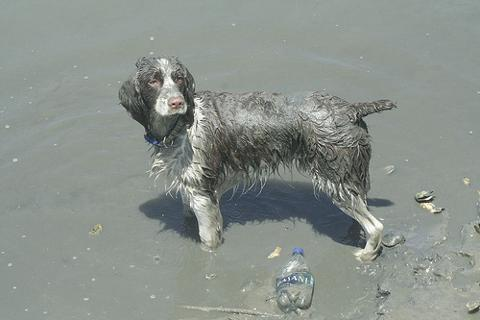

> Here's a description of the image:
> 
> Eye-level view of a wet, muddy dog standing in shallow, gray water. 
> 
> 
> Here's a breakdown of the details:
> 
> * **The Dog:** The dog appears to be a Springer Spaniel or a similar breed, with a predominantly dark brown/gray coat speckled with white. Its fur is matted and caked with mud, indicating it has been swimming or playing in the water. The dog is looking directly at the camera with a somewhat neutral expression. It's wearing a dark-colored collar.
> 
> * **The Water:** The water is very shallow, barely covering the dog's paws. It's a murky gray color, appearing muddy or silty.
> 
> * **The Setting:** The background is indistinct, just more of the same gray water and mud. There are a few small, dark objects scattered on the mud near the dog, possibly small shells or pebbles. A partially visible plastic water bottle lies in the mud near the dog's back legs.
> 
> * **Overall:** The image suggests a beach or shoreline setting where the dog has been enjoying the water. The overall mood is rather calm and slightly melancholic due to the muted colors and the slightly forlorn look on the dog's face. The image has a slightly grainy quality, as if taken with a less-than-high-resolution camera.


In [118]:
mm_rag("A wet dog in mud water")

In [100]:
# Remember to close the weaviate instance
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2024-11-20T13:01:40Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2024-11-20T13:01:40Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:cc051856-4e9a-4c08-b70d-3e4f810e4294 Type:TERMINATE Version:1.24.4 Modules:backup-filesystem,multi2vec-palm NumObjects:13594 OS:linux Arch:amd64}","time":"2024-11-20T13:01:41Z"}


### Try it yourself! 

Run the cells above selecting another image from the database and generate a description for it!